<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/grid_search_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [2]:
from itertools import product
import pandas as pd

In [23]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [3]:
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/traffic.txt", names=['col'])
df.index = pd.date_range(start='1/1/2016', freq="D", periods=len(df))

In [5]:
df.tail()

,col
2020-07-10,27760.294317
2020-07-11,27790.877540
2020-07-12,34913.459204
2020-07-13,57116.824376
2020-07-14,72690.783945


In [6]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, 
                 enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, percent_test=0.25):
  n_test = int(len(data) * percent_test)
  return data[:-n_test], data[-n_test:]

In [7]:
# walk-forward validation for univariate data
def walk_forward_validation(data, percent_test, cfg):

  # split dataset
  train, test = train_test_split(data, percent_test)

  # fit model and make forecast for history
  yhat = sarima_forecast(train, cfg)

  # estimate prediction error
  error = measure_rmse(test.iloc[0], [yhat])
  return error  

In [8]:
cfg = [[(1,1,1), (1,1,1,12), 'n'],[(2,1,1), (2,1,1,12), 'n']]

In [10]:
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

In [11]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [12]:
def sarima_configs(seasonal=[0]):
  models = list()
  # define config lists
  p_params = [0, 1]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n']#,'c','t','ct']
  P_params = [0, 1]
  D_params = [0, 1]
  Q_params = [0, 1]
  m_params = seasonal
  # create config instances
  for p, d, q, t, P, D, Q, m in product(p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    cfg = [(p,d,q), (P,D,Q,m), t]
    models.append(cfg)
  return models

In [13]:
cfg_list = sarima_configs(seasonal=[12])

In [ ]:
scores = grid_search(df, cfg_list, 0.25)

In [17]:
for cfg, error in scores[:3]:
		print(cfg, error)

[(1, 1, 2), (0, 1, 1, 12), 'n'] 234.75363243689935
[(1, 1, 1), (0, 1, 1, 12), 'n'] 294.46251458813276
[(1, 1, 0), (0, 1, 1, 12), 'n'] 486.21565429707334


In [20]:
sarimax_pred = SARIMAX(
    endog=df, order=(1, 1, 2), seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False, enforce_invertibility=False, freq='D')

model_sarimax_pred = sarimax_pred.fit()

In [28]:
model_sarimax_pred.predict()

2016-01-01        0.000000
2016-01-02    80370.621309
2016-01-03    76349.061141
2016-01-04    82189.166283
2016-01-05    77557.704166
                  ...     
2020-07-10    27695.014995
2020-07-11    27885.490956
2020-07-12    30280.787198
2020-07-13    45675.231709
2020-07-14    73523.822124
Freq: D, Length: 1657, dtype: float64

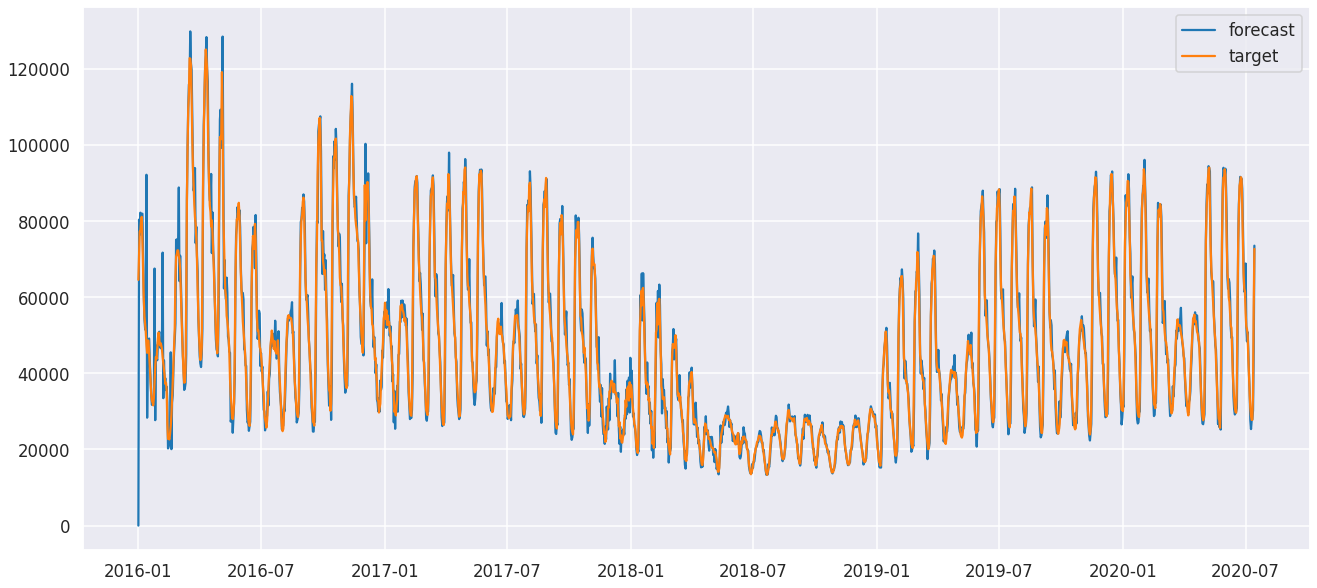

In [35]:
previsao_sarimax = model_sarimax_pred.predict()

plt.figure(figsize=(22, 10))
plt.plot(previsao_sarimax, label = 'forecast')
plt.plot(df, label = 'target')
plt.legend()
plt.show()